<div class="alert alert-warning">
    
<b>Disclaimer:</b> 
    
The main objective of the <i>Jupyter</i> notebooks is to show how to use the models of the <i>QENS library</i> by
    
- building a fitting model: composition of models, convolution with a resolution function  
- setting and running the fit  
- extracting and displaying information about the results  

These steps have a minimizer-dependent syntax. That's one of the reasons why different minimizers have been used in the notebooks provided as examples.  
But, the initial guessed parameters might not be optimal, resulting in a poor fit of the reference data.

</div>


# Lorentzian + Isotropic Rotational diffusion &lowast; Resolution with bumps

## Introduction

<div class="alert alert-info">
    
The objective of this notebook is to show how to use a combination of models from the QENS library <em>i.e.</em> <b>Lorentzian</b>  and <b>IsotropicRotationalDiffusion</b> models.
</div>

The data are a set of water data measured at IN5 (ILL).

**Reference:** J. Qvist, H. Schober and B. Halle, *J. Chem. Phys.* **134**, 144508 (2011)

### Physical units
For information about unit conversion, please refer to the jupyter notebook called `Convert_units.ipynb` in the `tools` folder.


## Import and install required libraries

In [1]:
from __future__ import print_function

# for interactivity (plots, buttons...)
import ipywidgets

import h5py
import QENSmodels
import numpy as np
from scipy.integrate import simps
import bumps.names as bmp
from bumps.fitters import fit
from bumps.formatnum import format_uncertainty

## Setting of fitting

### Import reference data

In [2]:
path_to_data = './data/'

# Data
# Wavelength 5 Angstrom
with h5py.File(path_to_data + 'H2O_293K_5A.hdf', 'r') as f:
    hw_5A = f['entry1']['data1']['X'][:]
    q_5A = f['entry1']['data1']['Y'][:]
    unit_w5A = f['entry1']['data1']['X'].attrs['long_name']
    unit_q5A = f['entry1']['data1']['Y'].attrs['long_name']
    sqw_5A = np.transpose(f['entry1']['data1']['DATA'][:])
    err_5A = np.transpose(f['entry1']['data1']['errors'][:])

# Resolution
# Wavelength 5 Angstrom
with h5py.File(path_to_data + 'V_273K_5A.hdf', 'r') as f:
    res_5A = np.transpose(f['entry1']['data1']['DATA'][:])

# Force resolution function to have unit area
# Wavelength 5 Angstrom
for i in range(len(q_5A)):
    area = simps(res_5A[:, i], hw_5A)
    res_5A[:, i] /= area

# Fit range -1 to +1 meV
idx_5A = np.where(np.logical_and(hw_5A > -1.0, hw_5A < 1.0))

# Fitting model
def model_convol(x, q, scale=1, center=0, hwhm=1, radius=1, DR=1, resolution=None):
    model = QENSmodels.lorentzian(x, scale, center, hwhm) + QENSmodels.sqwIsotropicRotationalDiffusion(x, q, scale, center, radius, DR)
    return np.convolve(model, resolution/resolution.sum(), mode='same')

### Display units of input data 
Just for information in order to determine if a conversion of units is required before using the QENSmodels

In [3]:
print(f"At 5 Angstroms, the names and units of `w` (`x`axis) and `q` are: {unit_w5A[0].decode()} and {unit_q5A[0].decode()}, respectively.")

At 5 Angstroms, the names and units of `w` (`x`axis) and `q` are:  Energy Transfer (meV) and Wavevector Transfer (A!U-1!N), respectively.


### Create fitting model

In [4]:
# Fit
Model = []

for i in range(len(q_5A)):

    x = hw_5A[idx_5A]
    data = sqw_5A[idx_5A, i]
    error = err_5A[idx_5A, i]
    resol = res_5A[idx_5A, i]

    # Select only valid data (error = -1 for Q, w points not accessible)
    valid = np.where(error > 0.0)
    x = x[valid[1]]
    data = data[valid]
    error = error[valid]
    resol = resol[valid]

    # model
    Modelq = bmp.Curve(model_convol, x, data, error, q=q_5A[i], scale=15,
                   center=0.0, hwhm=0.1, radius=1.1, DR=1., resolution=resol)

    # Fitted parameters
    Modelq.scale.range(0, 1e2)
    Modelq.center.range(-0.1, 0.1)
    Modelq.hwhm.range(0., 1)
    Modelq.radius.range(0.9, 1.1)
    Modelq.DR.range(0.01, 5)

    # Q-independent parameters
    if i == 0:
        Qhwhm = Modelq.hwhm
        QR = Modelq.radius
        QDR = Modelq.DR
    else:
        Modelq.hwhm = Qhwhm
        Modelq.radius = QR
        Modelq.DR = QDR

    Model.append(Modelq)

problem = bmp.FitProblem(Model)

#### Choice of minimizers

In [5]:
options_dict={'Levenberg-Marquardt': "lm", 
             'Nelder-Mead Simplex': "amoeba", 
             'DREAM': "dream", 
             'Differential Evolution': "de", 
             'Quasi-Newton BFGS': "newton", 
             'Random Lines (experimental)': "rl", 
             'Particle Swarm (experimental)': "ps", 
             'Parallel Tempering (experimental)': "pt"}

w_choice_minimizer = ipywidgets.Dropdown(
    options=list(options_dict.keys()),
    value='Levenberg-Marquardt',
    description='Minimizer:',
    layout=ipywidgets.Layout(height='40px')
)
w_choice_minimizer

Dropdown(description='Minimizer:', layout=Layout(height='40px'), options=('Levenberg-Marquardt', 'Nelder-Mead …

### Setting for running bumps

In [6]:
steps_fitting = ipywidgets.IntText(
    value=100,
    description='Number of steps when fitting',
    style={'description_width': 'initial'})

steps_fitting

IntText(value=100, description='Number of steps when fitting', style=DescriptionStyle(description_width='initi…

Initial chisq 43394.549(31)


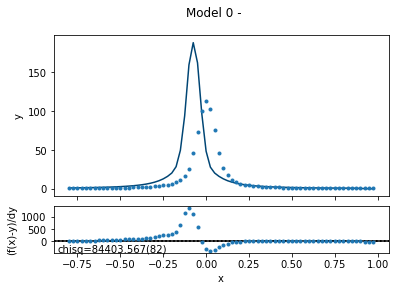

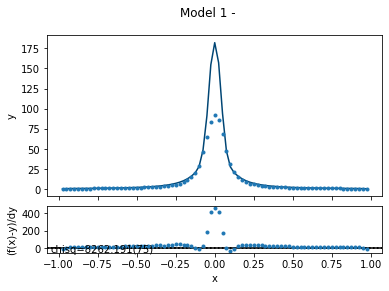

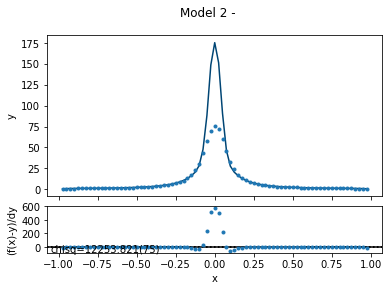

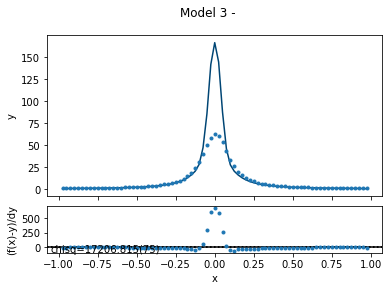

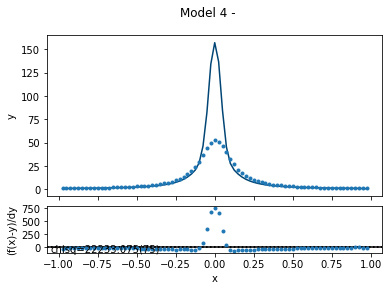

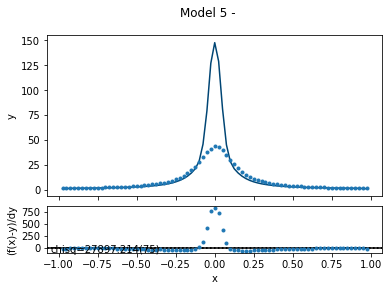

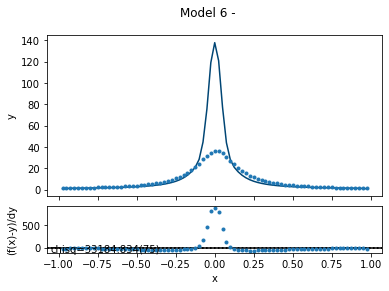

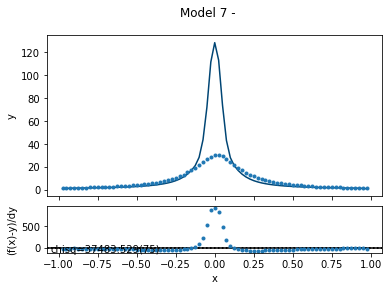

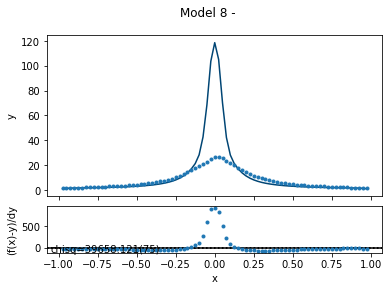

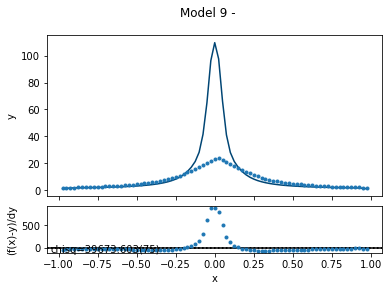

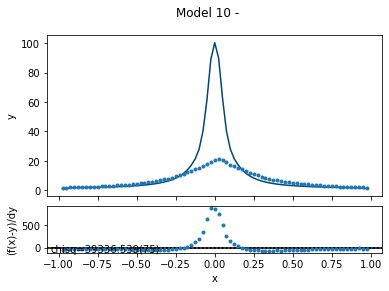

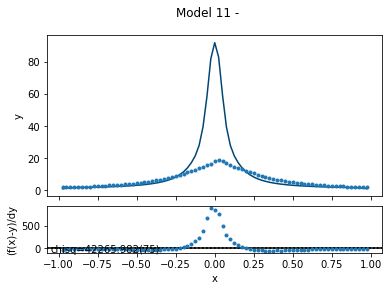

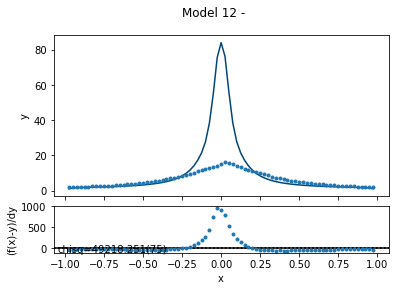

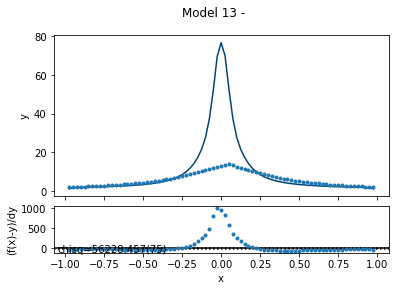

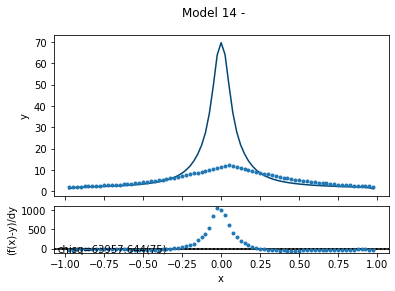

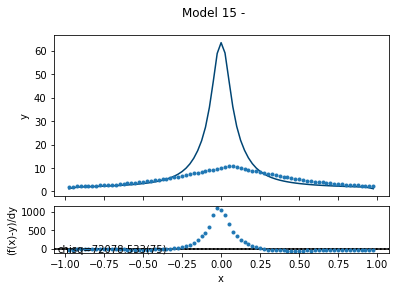

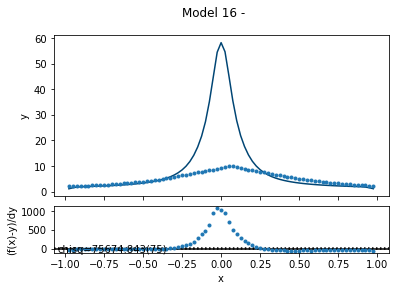

In [7]:
# Preview of the settings
print('Initial chisq', problem.chisq_str())
problem.plot()

## Running the fit

Run the fit using the *minimizer* defined above with a number of *steps* also specified above.

In [8]:
result = fit(problem, 
             method=options_dict[w_choice_minimizer.value], 
             steps=int(steps_fitting.value))

## Showing the results

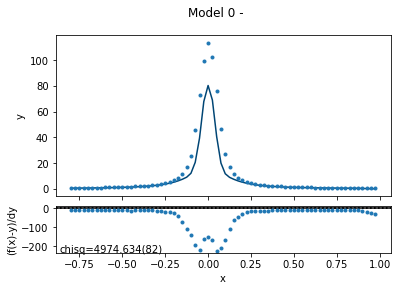

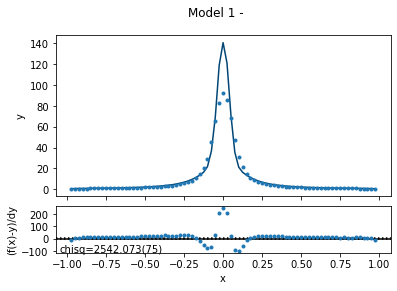

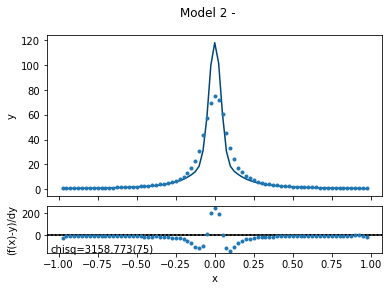

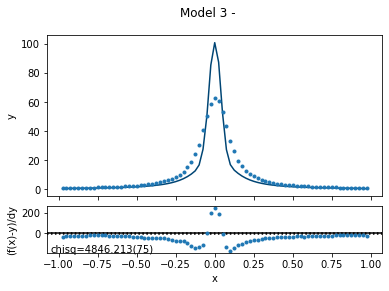

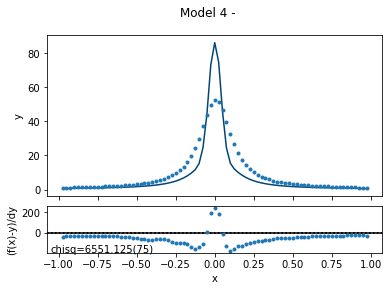

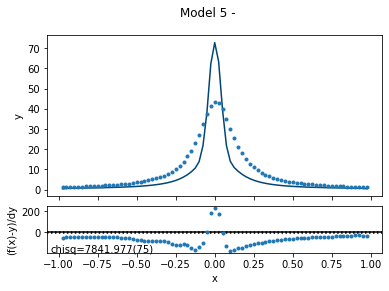

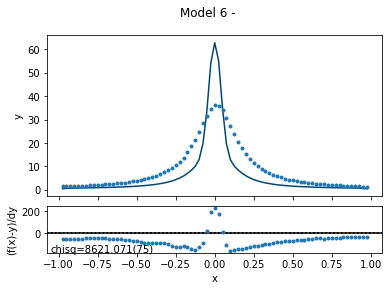

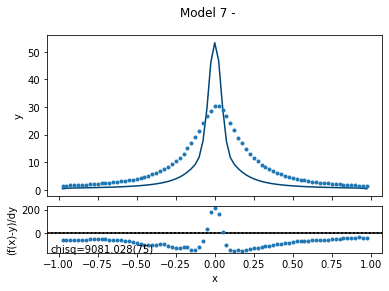

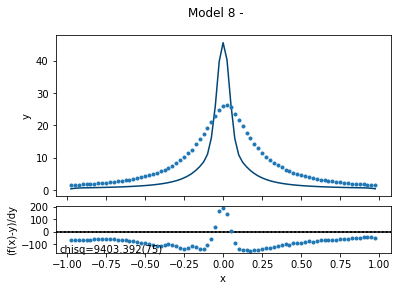

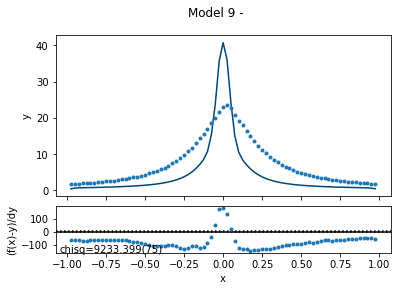

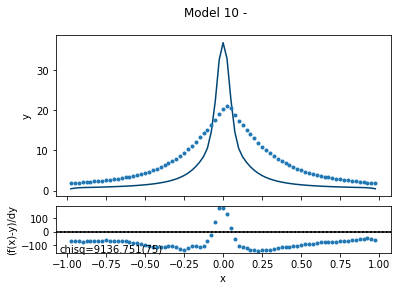

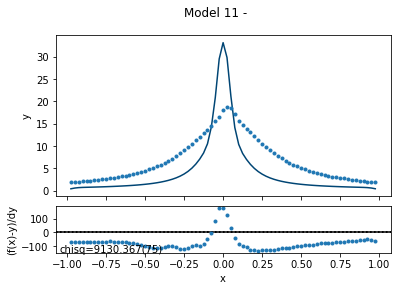

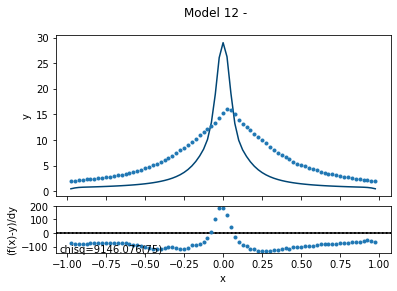

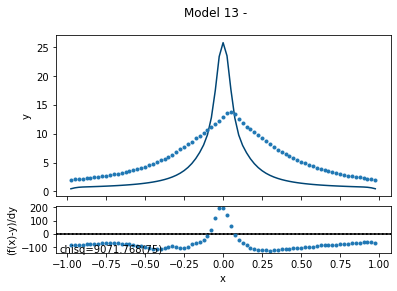

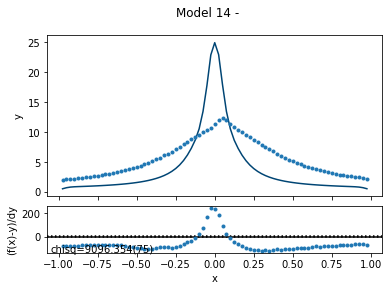

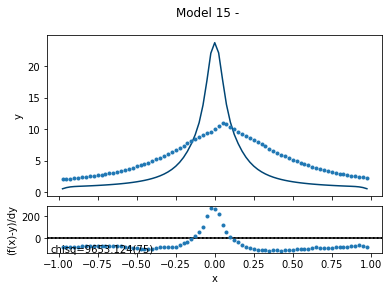

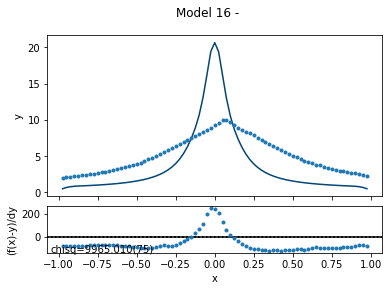

In [9]:
problem.plot()

In [10]:
# Print chi**2 and parameters' values after fit
print("final chisq", problem.chisq_str())
for k, v, dv in zip(problem.labels(), result.x, result.dx):
    print(k, ":", format_uncertainty(v, dv))

final chisq 7967.648(31)
DR : 1.0000(50)
center : 0.07432(28)
hwhm : 0.12772(14)
radius : 1.10000(67)
scale : 6.6893(71)
center : -0.12(13)e-3
scale : 12.1413(71)
center : 0.00166(21)
scale : 10.5889(71)
center : 0.00270(24)
scale : 9.5317(70)
center : 0.00268(27)
scale : 8.6783(69)
center : 0.00181(29)
scale : 7.8229(68)
center : 0.91(32)e-3
scale : 7.2582(68)
center : 0.35(27)e-3
scale : 6.6515(68)
center : -0.64(35)e-3
scale : 6.1802(68)
center : -0.91(32)e-3
scale : 6.0167(71)
center : -0.97(29)e-3
scale : 5.9910(72)
center : -0.99(29)e-3
scale : 5.9402(73)
center : -0.00136(28)
scale : 5.7230(72)
center : -0.00103(25)
scale : 5.6231(71)
center : -0.75(24)e-3
scale : 6.0586(72)
center : -0.08(17)e-3
scale : 6.4008(78)
center : -0.00182(20)
scale : 6.1354(72)
